In [1]:
from datetime import date
from datetime import datetime
import numpy as np
from scipy.stats import norm
from scipy.optimize import minimize_scalar   
import pandas as pd
import pandas_datareader.data as web
import datetime as dt
from numpy import arange
from pandas import read_csv
from scipy.optimize import curve_fit
import matplotlib.pyplot as plt
from scipy import stats
from scipy.optimize import differential_evolution

In [2]:
from google.colab import drive
drive.mount('/content/drive')
%cd "/content/drive/My Drive/TCC Giulia/séries históricas 00-22/"

Mounted at /content/drive
/content/drive/My Drive/TCC Giulia/séries históricas 00-22


In [3]:
        
def objective(x, a, b, rho, sigma, m):
	return a + b*(rho*(x-m)+ np.sqrt((x-m)**2 + sigma**2))

#def objective(x, a, b, c):
#    return a * x + b * x**2 + c
def my_function(x):
  return list( dict.fromkeys(x) )

In [4]:
a = pd.read_csv('Volatilidades_PETR_2911_2010.csv')

In [5]:
a['NS'] = np.log(a['preco_exerc']/(a['spot']*(1+a['selic'])**(a["dias_ate_vencimento"]/252)))

In [6]:
a['variancia'] = (a["dias_ate_vencimento"]/252)*a['volatilidade']**2


In [7]:
def my_func(x):
    if x['cod_bdi'] ==78 and x['preco_exerc'] > x['spot']:
        val = -1
    elif x["cod_bdi"] == 82 and x['preco_exerc'] < x['spot']:
        val = -1
    else:
        val = 1
    return val

a['status'] = a.apply(my_func, axis=1)
a = a[a['status'] > 0]

a.head()

,Unnamed: 0,data_pregao,cod_papel,preco_medio,data_vencimento,preco_exerc,cod_bdi,espec_papel,spot,selic,dias_ate_vencimento,volatilidade,NS,variancia,status
0,289,2010-01-04 00:00:00,PETRA28,9.29,2010-01-18 00:00:00,27.83,78,PN,37.1,0.0875,10,0.157355,-0.290831,0.000983,1
1,290,2010-01-04 00:00:00,PETRA30,7.58,2010-01-18 00:00:00,29.66,78,PN,37.1,0.0875,10,0.584637,-0.227146,0.013564,1
2,291,2010-01-04 00:00:00,PETRA32,6.18,2010-01-18 00:00:00,31.07,78,PN,37.1,0.0875,10,0.492117,-0.180703,0.009610,1
3,292,2010-01-04 00:00:00,PETRA34,3.84,2010-01-18 00:00:00,33.41,78,PN,37.1,0.0875,10,0.308890,-0.108090,0.003786,1
4,293,2010-01-04 00:00:00,PETRA36,1.86,2010-01-18 00:00:00,35.66,78,PN,37.1,0.0875,10,0.298680,-0.042916,0.003540,1


In [8]:
a = a[a['status'] > 0]

In [9]:
def func(parameters, *data):

    #we have 3 parameters which will be passed as parameters and
    #"experimental" x,y which will be passed as data

    alpha, beta, rho, sigma, m = parameters
    x,y = data


    result = 0

    for i in range(len(x)):
        result += (alpha + beta * (rho * (x[i] - m) + np.sqrt((x[i] - m)**2 + sigma**2)) - y[i])**2
    return result

3.6029443259718166e-06 0.007786830386580289 -0.902434274931263 0.000687692443534312 0.2191339803172396


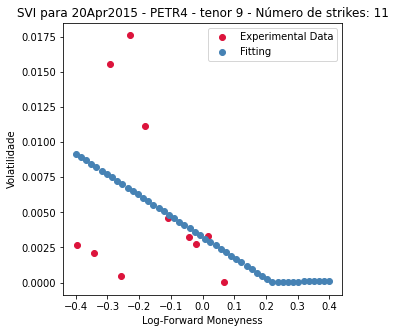

0.008174369800222809 0.032452223957251954 -0.9689372644841902 0.008010454345746034 -0.05948874862035707


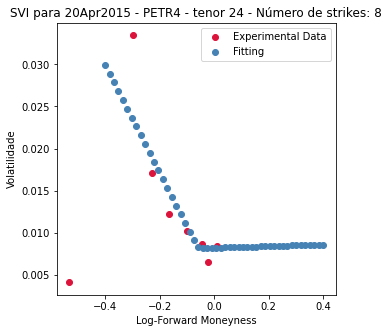

0.01693989155654632 0.015747343166854298 -0.8238378937765817 0.18213445251358804 -0.05925579904434719


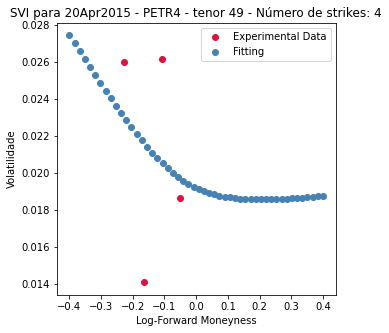

In [10]:
#teste para uma data específica
c = a[a['data_pregao']== '2010-01-05 00:00:00']
tenors = my_function(c['dias_ate_vencimento'].to_list())
tenors.sort()
x = np.linspace(-0.4, 0.4, 50, endpoint=True)
for tenor in tenors:
    result = 0
    d = c[c['dias_ate_vencimento']== tenor]
    if(tenor>0 and len(d['NS'].to_list()) > 2):
        y1 = d['variancia'].to_list()
        x1 = d['NS'].to_list()

        y = np.interp(x, x1, y1)

        bounds = [(0., max(y)), (0.,4/(tenor/252)), (-1, 1),      (1e-5, 5), (np.min(x), np.max(x))]
        
        args = (x,y)

        result = differential_evolution(func, bounds, args=args)
        alpha,beta,rho,sigma, m = result.x
        
        print(alpha,beta,rho,sigma, m)
        plt.figure(figsize=(5, 5))

        # define a sequence of inputs between the smallest and largest known inputs

        # calculate the output for the range
        y2 = alpha + beta * (rho * (x - m) + np.sqrt((x - m)**2 + sigma**2))

        colors = ['crimson', 'steelblue', 'seagreen']

        plt.scatter(x1,y1, label='Experimental Data', color = colors[0])
        plt.scatter(x,y2, label='Fitting', color = colors[1])

        plt.title("SVI para 20Apr2015 - PETR4 - tenor " + str(tenor) + " - Número de strikes: " + str(len(x1)))
        plt.ylabel("Volatilidade")
        plt.xlabel("Log-Forward Moneyness")
        plt.legend()
        plt.show()

In [11]:
mylist = my_function(a['data_pregao'].to_list())
#mylist = ["2010-01-05 00:00:00"]
lista_parâmetros = []
matriz_tenors = []
lista_tenor = []
lista_tenors_final =[]
last_popt = []
date_list = []
x = np.linspace(-0.4, 0.4, 50, endpoint=True)
for day in mylist:
    lista_tenor = []
    lista_param_tenor = []
    c = a[a['data_pregao']== day]
    tenors = my_function(c['dias_ate_vencimento'].to_list())
    tenors.sort()
    count = 0
    for tenor in tenors:
        d = c[c['dias_ate_vencimento']== tenor]
        if(tenor > 0 and len(d['data_pregao'].to_list())>2):
            y1 = d['variancia'].to_list()
            x1 = d['NS'].to_list()

            y = np.interp(x, x1, y1)

            bounds = [(0., np.max(y)), (0.,4/(tenor/252)), (-0.7, 0.7),      (1e-5, 2), (np.min(x), np.max(x))]
            args = (x,y)

            result = differential_evolution(func, bounds, args=args)

            alpha,beta,rho,sigma, m= result.x

            # define a sequence of inputs between the smallest and largest known inputs

            # calculate the output for the range
            lista_param_tenor.append([alpha, beta, rho, sigma, m])
            lista_tenor.append(tenor)
            if count == 0:
              date_list.append(day)
            count += 1        
    lista_tenors_final.append(lista_tenor)
    lista_parâmetros.append(lista_param_tenor)

In [15]:
interpolacao = [7, 14, 21,  30, 60]
lista_alpha = []
lista_beta = []
lista_rho = []
lista_sigma = []
lista_m = []
lista_a_7dias = []
lista_b_7dias=[]
lista_rho_7dias=[]
lista_sigma_7dias=[]
lista_m_7dias=[]

lista_a_14dias = []
lista_b_14dias=[]
lista_rho_14dias=[]
lista_sigma_14dias=[]
lista_m_14dias=[]

lista_a_21dias = []
lista_b_21dias=[]
lista_rho_21dias=[]
lista_sigma_21dias=[]
lista_m_21dias=[]

lista_a_30dias = []
lista_b_30dias=[]
lista_rho_30dias=[]
lista_sigma_30dias=[]
lista_m_30dias=[]

lista_a_60dias = []
lista_b_60dias=[]
lista_rho_60dias=[]
lista_sigma_60dias=[]
lista_m_60dias=[]


new_data = []
for i in range(len(lista_parâmetros)):
    lista_alpha = []
    lista_beta = []
    lista_rho = []
    lista_sigma = []
    lista_m = []
    for lista in lista_parâmetros[i]:
        lista_alpha.append(lista[0])
        lista_beta.append(lista[1])
        lista_rho.append(lista[2])
        lista_sigma.append(lista[3])
        lista_m.append(lista[4])
    try:
        lista_a_interpolada = np.interp(interpolacao, lista_tenors_final[i], lista_alpha)
        lista_b_interpolada = np.interp(interpolacao, lista_tenors_final[i], lista_beta)
        lista_rho_interpolada = np.interp(interpolacao, lista_tenors_final[i], lista_rho)
        lista_sigma_interpolada = np.interp(interpolacao, lista_tenors_final[i], lista_sigma)
        lista_m_interpolada = np.interp(interpolacao, lista_tenors_final[i], lista_m)
        lista_a_7dias.append(lista_a_interpolada[0])
        lista_b_7dias.append(lista_b_interpolada[0])
        lista_rho_7dias.append(lista_rho_interpolada[0])
        lista_sigma_7dias.append(lista_sigma_interpolada[0])
        lista_m_7dias.append(lista_m_interpolada[0])

        lista_a_14dias.append(lista_a_interpolada[1])
        lista_b_14dias.append(lista_b_interpolada[1])
        lista_rho_14dias.append(lista_rho_interpolada[1])
        lista_sigma_14dias.append(lista_sigma_interpolada[1])
        lista_m_14dias.append(lista_m_interpolada[1])

        lista_a_21dias.append(lista_a_interpolada[2])
        lista_b_21dias.append(lista_b_interpolada[2])
        lista_rho_21dias.append(lista_rho_interpolada[2])
        lista_sigma_21dias.append(lista_sigma_interpolada[2])
        lista_m_21dias.append(lista_m_interpolada[2])

        lista_a_30dias.append(lista_a_interpolada[3])
        lista_b_30dias.append(lista_b_interpolada[3])
        lista_rho_30dias.append(lista_rho_interpolada[3])
        lista_sigma_30dias.append(lista_sigma_interpolada[3])
        lista_m_30dias.append(lista_m_interpolada[3])

        lista_a_60dias.append(lista_a_interpolada[4])
        lista_b_60dias.append(lista_b_interpolada[4])
        lista_rho_60dias.append(lista_rho_interpolada[4])
        lista_sigma_60dias.append(lista_sigma_interpolada[4])
        lista_m_60dias.append(lista_m_interpolada[4])


        new_data.append(mylist[i])
    except:
        pass
    

In [25]:
lista_7 = []
lista_14 = []
lista_21 = []
lista_30 = []
lista_60 = []
for i in range(len(date_list)):
  lista_7.append(7)
  lista_14.append(14)
  lista_21.append(21)
  lista_30.append(30)
  lista_60.append(60)

lista_a = lista_a_7dias + lista_a_14dias + lista_a_21dias + lista_a_30dias + lista_a_60dias
lista_b = lista_b_7dias + lista_b_14dias + lista_b_21dias + lista_b_30dias + lista_b_60dias
lista_rho = lista_rho_7dias + lista_rho_14dias + lista_rho_21dias + lista_rho_30dias + lista_rho_60dias
lista_sigma = lista_sigma_7dias + lista_sigma_14dias + lista_sigma_21dias + lista_sigma_30dias + lista_sigma_60dias
lista_m = lista_m_7dias + lista_m_14dias + lista_m_21dias + lista_m_30dias + lista_m_60dias

data_final = date_list + date_list + date_list + date_list + date_list
dias = lista_7 + lista_14 + lista_21 + lista_30 + lista_60

dict_to_be_saved = {'a': lista_a,
                    'b': lista_b,
                    'rho': lista_rho,
                    'sigma': lista_sigma,
                    'm': lista_m,
                    'date': data_final,
                    'dias': dias 
}

dados_interpolados2 = pd.DataFrame.from_dict(dict_to_be_saved)
dados_interpolados2 = dados_interpolados2.sort_values(by="date")
multi = dados_interpolados2.set_index(['date', 'dias'])

multi.to_csv("DadosPivoteados_PETR_2010_20.csv")

In [14]:
multi.to_csv("DadosPivoteados_PETR_2010_09.csv")

Text(0.5, 1.0, 'Parameter a')

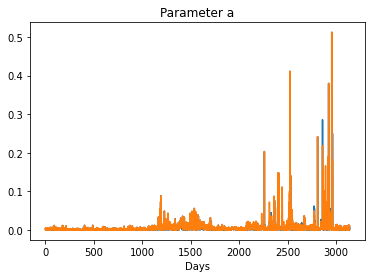

In [17]:
import matplotlib.pyplot as plt
#plt.plot(lista_a_7dias)

#plt.xlabel('Days')
#plt.title('Parameter a')

plt.plot(lista_a_7dias)
plt.plot(lista_a_14dias)
plt.xlabel('Days')
plt.title('Parameter a')


Text(0.5, 1.0, 'Parameter rho')

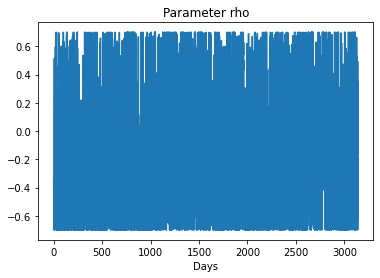

In [18]:

plt.plot(lista_rho_14dias)


plt.xlabel('Days')
plt.title('Parameter rho')

In [24]:
multi

a         b       rho     sigma         m
date                dias                                                  
2010-01-04 00:00:00 7     0.002905  0.002125 -0.354691  0.024626  0.328725
                    21    0.006620  0.013228 -0.311017  0.055650  0.224273
                    30    0.009783  0.025314 -0.376108  0.067674  0.150707
                    60    0.017030  0.057507 -0.700000  0.070643  0.008371
                    14    0.004256  0.006162 -0.338809  0.035908  0.290742
...                            ...       ...       ...       ...       ...
2022-09-09 00:00:00 30    0.031184  0.006801  0.092475  0.000385 -0.366225
                    14    0.011088  0.043289  0.488305  0.004233 -0.076711
                    7     0.002464  0.060692  0.652957  0.006204  0.074157
                    21    0.019712  0.025886  0.323653  0.002262 -0.227579
                    60    0.022561  0.032796  0.231490  1.004979 -0.183596

[15710 rows x 5 columns]

Text(0.5, 1.0, 'Parameter b')

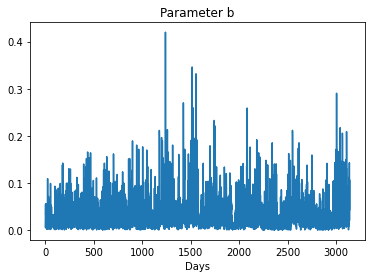

In [19]:

plt.plot(lista_b_14dias)
plt.xlabel('Days')
plt.title('Parameter b')

Text(0.5, 1.0, 'Parameter m')

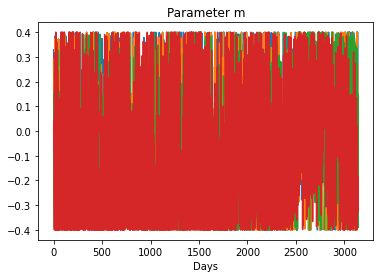

In [20]:
plt.plot(lista_m_7dias)
plt.plot(lista_m_14dias)
plt.plot(lista_m_30dias)
plt.plot(lista_m_60dias)
plt.xlabel('Days')
plt.title('Parameter m')

Text(0.5, 1.0, 'Parameter sigma')

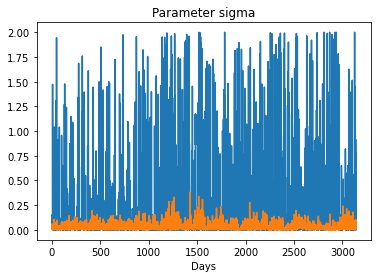

In [21]:
plt.plot(lista_sigma_21dias)
plt.plot(lista_b_21dias)

plt.xlabel('Days')
plt.title('Parameter sigma')

In [ ]:
import ast
res = ast.literal_eval(ini_list)

In [22]:
dict_to_save = {'alpha7dias': lista_a_7dias,
                'beta7dias': lista_b_7dias,
                'rho7dias': lista_rho_7dias,
                'sigma7dias': lista_sigma_7dias,
                'm7dias': lista_m_7dias,

                'alpha14dias': lista_a_14dias,
                'beta14dias': lista_b_14dias,
                'rho14dias': lista_rho_14dias,
                'sigma14dias': lista_sigma_14dias,
                'm14dias': lista_m_14dias,
                
                'alpha21dias': lista_a_21dias,
                'beta21dias': lista_b_21dias,
                'rho21dias': lista_rho_21dias,
                'sigma21dias': lista_sigma_21dias,
                'm21dias': lista_m_21dias,
                
                'alpha30dias': lista_a_30dias,
                'beta30dias': lista_b_30dias,
                'rho30dias': lista_rho_30dias,
                'sigma30dias': lista_sigma_30dias,
                'm30dias': lista_m_30dias,
                
                'alpha60dias': lista_a_60dias,
                'beta60dias': lista_b_60dias,
                'rho60dias': lista_rho_60dias,
                'sigma60dias': lista_sigma_60dias,
                'm60dias': lista_m_60dias,

                'data_pregao': date_list
                
}

In [23]:
dados_interpolados = pd.DataFrame.from_dict(dict_to_save)
dados_interpolados.to_csv("ListaInterpolada_PETR_2010_12.csv")

In [ ]:
df_recupera = pd.read_csv("Salvando233.csv")
lista_parâmetros = df_recupera['params'].to_list()
lista_tenors_final = df_recupera['tenors'].to_list()
datas_pregao = df_recupera['data_pregao'].to_list()

FileNotFoundError: ignored

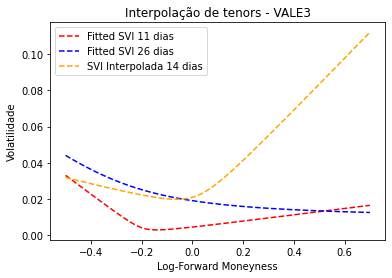

In [ ]:
a1 = lista_alpha[0]
b1 = lista_beta[0]
r1 = lista_rho[0]
s1 = lista_sigma[0]
m1 = lista_m[0]

a14 = lista_a_14dias[0]
b14 = lista_b_14dias[0]
r14 = lista_rho_14dias[0]
s14 = lista_sigma_14dias[0]
m14= lista_m_14dias[0]

a2 = lista_alpha[1]
b2 = lista_beta[1]
r2 = lista_rho[1]
s2 = lista_sigma[1]
m2 = lista_m[1]


x_line = np.arange(-0.5, 0.7, 0.001)

y_line = objective(x_line, a1, b1, r1, s1, m1)
y_line2 = objective(x_line, a2, b2, r2, s2, m2)
y_line3 = objective(x_line, a14, b14, r14, s14, m14)
plt.plot(x_line, y_line, '--', color='red', label = 'Fitted SVI 11 dias')
plt.plot(x_line, y_line2, '--', color='blue', label ='Fitted SVI 26 dias')
plt.plot(x_line, y_line3, '--', color='orange', label='SVI Interpolada 14 dias')

plt.title("Interpolação de tenors - VALE3")
plt.ylabel("Volatilidade")
plt.xlabel("Log-Forward Moneyness")
plt.legend()

plt.show()